In [1]:
%pylab notebook

# LOFAR failure analysis: main notebook
# V.A. Moss (vmoss.astro@gmail.com)
__author__ = "V.A. Moss"
__date__ = "$25-apr-2019 17:00:00$"
__version__ = "1.0"

import os
import sys
import time
rc('text', usetex=False)
rc('font',**{'size':9,'weight':'normal'})
from astropy.io import ascii
import datetime
import operator

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Initialisation values
csv_name = 'input/LOFAR Observing Failures (Responses) - Form Responses 1.csv'
save_loc = 'results/'

# Which cycle is it?
cyc = 'Cycle 11'
start_date = datetime.datetime.strptime('2019-02-21','%Y-%m-%d')
end_date = datetime.datetime.strptime('2019-04-26','%Y-%m-%d')
today = datetime.datetime.today().strftime('%d %b %Y')
today_save = str(datetime.datetime.utcnow().date())

# Files to use for historical plotting
files = ['input/Cycle8-Part1.csv',
         'input/Cycle8-Part2.csv',
        'input/Cycle9-Part1.csv',
        'input/Cycle9-Part2.csv',
        'input/Cycle10-Part1.csv',
        'input/Cycle10-Part2.csv',
        'input/Cycle11-Part1.csv',
        'input/LOFAR Observing Failures (Responses) - Form Responses 1.csv']

In [3]:
# Read in the CSV file
d_all = ascii.read(csv_name)
print (d_all.keys())
print()

# Limited by dates specified above
dates = np.array([datetime.datetime.strptime(x,'%m/%d/%Y') for x in d_all['Date of observation:']])
mask = (dates >= start_date) & (dates <= end_date)
d = d_all[mask]

print('Total length of CSV:',len(d_all))
print('Length of CSV subset:',len(d))

['Timestamp', 'Email Address', 'Date of observation:', 'Project code:', 'SAS ID:', 'Main failure category:', 'Sub-category:', 'Brief description of the cause of the failure:', 'Number of hours lost:', 'LST range of hours lost:', 'Is this a repeat?', 'Did the PI accept it anyway?', 'Any further comments:']

Total length of CSV: 16
Length of CSV subset: 8


{'LT10_006': 1, 'LC11_005': 2, 'LT10_010': 1, 'LT10_005': 1, 'LC11_009': 1, 'LT10_002': 1, 'SDF-PPE': 1}
Total projects: 8
Total unique projects: 7


<IPython.core.display.Javascript object>


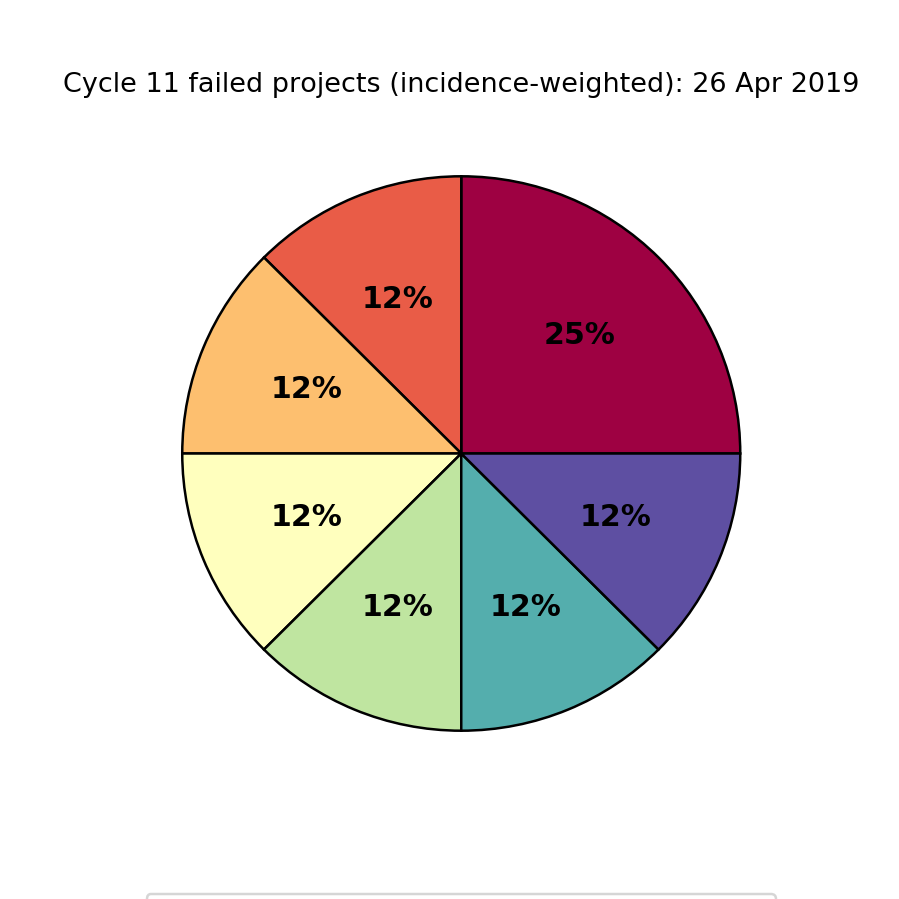

In [4]:
# Pie chart of project codes
pcodes = {}
unique = (list(set(d['Project code:'])))
for x in unique:
    xname = '_'.join(x.split('_'))
    pcodes[xname] = list(d['Project code:']).count(x)
print (pcodes)
print ( 'Total projects: %i' % (sum(list(pcodes.values()))))
print  ('Total unique projects: %i' % len(unique))

sorted_p = sorted(pcodes.items(), key=operator.itemgetter(1))
values,keys = [],[]
for x in sorted_p:
    values.append(x[1])
    keys.append(x[0])
    
coldict = {}
clist = [cm.Spectral(x) for x in linspace(0,1,len(pcodes))]
clist2 = clist[::-1]
for i in range(0,len(keys)):
    coldict[keys[i]] = clist2[i]

# Make the pie chart
figure(figsize=(5,5))
title('%s failed projects (incidence-weighted): %s' % (cyc,today))
patches, texts, autotexts = pie(values[::-1],colors=clist,wedgeprops = {'linewidth': 1,'edgecolor':'k'},autopct='%1.0f%%')
legend(tuple(patches), tuple(keys[::-1]), loc=8,ncol=3,bbox_to_anchor=(0.5,-0.3))
masterpatches,masterkeys = patches,keys
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')
    autotext.set_size(12)
savefig('%s/%s_failedprojects_%s.png' % (save_loc,''.join(cyc.split()),today_save),bbox_inches='tight',dpi=200)


LT10_006 7.0
LC11_005 8.33
LT10_010 8.0
LT10_005 1.0
LC11_009 8.33
LT10_002 5.0
SDF-PPE 4.0


<IPython.core.display.Javascript object>


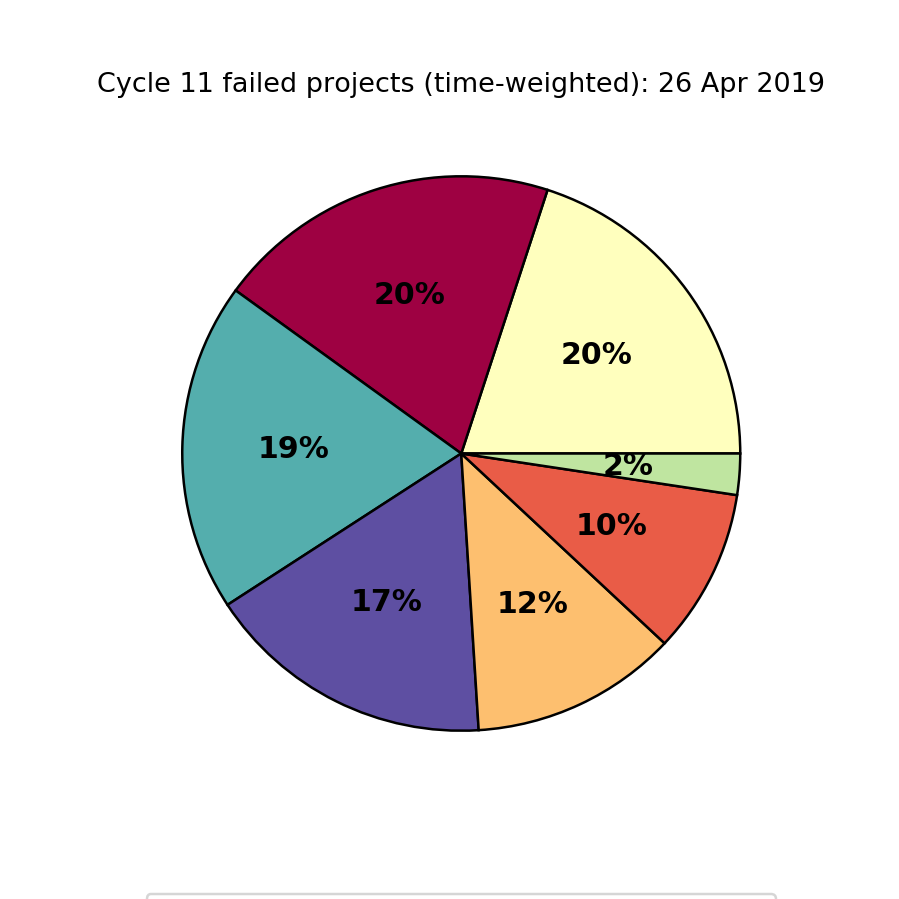

In [5]:
# Make the pie chart (weighted by time)
pcodes_time = {}
unique = list(set(d['Project code:']))
for x in unique:
    xname = '_'.join(x.split('_'))
    
    # Get the amount of time
    mask = (d['Project code:'] == x)
    dsub = d[mask]
    losttime = sum(dsub['Number of hours lost:'])    
    #pcodes_time[xname] = list(d['PROJECT CODE']).count(x)*losttime
    pcodes_time[xname] = losttime
    print( xname,losttime)
    
sorted_ptime = sorted(pcodes_time.items(), key=operator.itemgetter(1))
values,keys = [],[]
for x in sorted_ptime:
    values.append(x[1])
    keys.append(x[0])
    
# Keep the same colours
clist = []
for x in keys:
    clist.append(coldict[x])
clist = clist[::-1]
    
figure(figsize=(5,5))
title('Failed projects (time weighted)')
title('%s failed projects (time-weighted): %s' % (cyc,today))
patches, texts, autotexts = pie(values[::-1],labeldistance=1.2,colors=clist,wedgeprops = {'linewidth': 1,'edgecolor':'k'},autopct='%1.0f%%')#,pctdistance=1.1)
legend(tuple(masterpatches), tuple(masterkeys[::-1]), loc=8,ncol=3,bbox_to_anchor=(0.5,-0.3))
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')
    autotext.set_size(12)
savefig('%s/%s_failedprojects_timeweighted_%s.png' % (save_loc,''.join(cyc.split()),today_save),bbox_inches='tight',dpi=200)

HUMAN
HUMAN
NETWORK
HUMAN
STATION
STATION
HUMAN
HUMAN
NETWORK (0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0)
STATION (0.998077662437524, 0.9992310649750096, 0.7460207612456747, 1.0)
HUMAN (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)


<IPython.core.display.Javascript object>


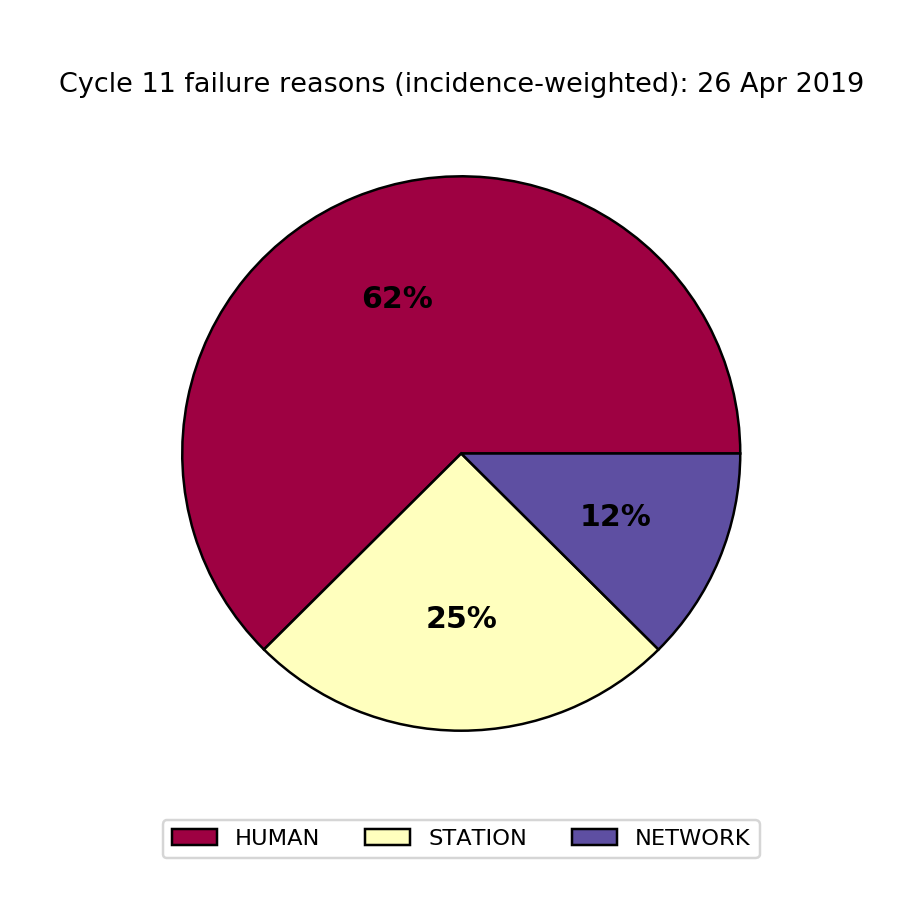

In [6]:
# Make the pie chart (weighted by category)
catcodes = {}
allcodes = []
for i in range(0,len(d['Main failure category:'])):
    print(d['Main failure category:'][i])
    cat = [x.strip() for x in d['Main failure category:'][i].split(',')]
    for j in cat:
        allcodes.append(j)
unique = list(set(allcodes))
for x in unique:
    catcodes[x] = allcodes.count(x)
    
sorted_cat = sorted(catcodes.items(), key=operator.itemgetter(1))
values,keys = [],[]
for x in sorted_cat:
    values.append(x[1])
    keys.append(x[0])
    
coldict = {}
clist = [cm.Spectral(x) for x in linspace(0,1,len(catcodes.keys()))]
clist2 = clist[::-1]
for i in range(0,len(keys)):
    print (keys[i],clist2[i])
    coldict[keys[i]] = clist2[i]    

figure(figsize=(5,5))
title('%s failure reasons (incidence-weighted): %s' % (cyc,today))
patches,texts,autotexts = pie(values[::-1],labeldistance=1.2,colors=clist,wedgeprops = {'linewidth': 1,'edgecolor':'k'},autopct='%1.0f%%')
legend(tuple(patches), tuple(keys[::-1]), loc=8,ncol=3,bbox_to_anchor=(0.5,-0.1))
masterpatches,masterkeys = patches,keys
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')
    autotext.set_size(12)
savefig('%s/%s_failurereasons_%s.png' % (save_loc,''.join(cyc.split()),today_save),bbox_inches='tight',dpi=200)

<IPython.core.display.Javascript object>


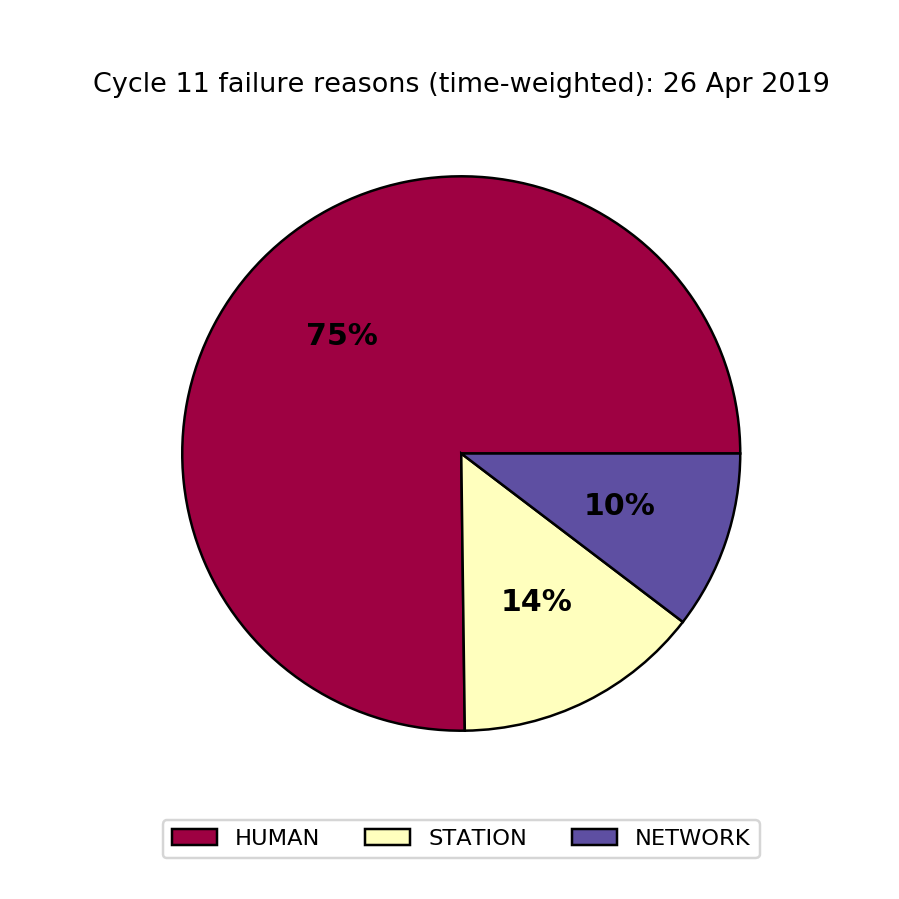

In [7]:
# Make the pie chart (weighted by category and time)
catcodes = {}
cattime = {}
allcodes = []
for i in range(0,len(d['Main failure category:'])):
    cat = [x.strip() for x in d['Main failure category:'][i].split(',')]
    timelost = d['Number of hours lost:'][i]
    divtime = timelost/float(len(cat))
    for j in cat:
        allcodes.append(j)
        
        # Append to time
        if j in cattime.keys():
            cattime[j]+=divtime
        else:
            cattime[j] = divtime
        
unique = list(set(allcodes))
for x in unique:
    tottime = sum(cattime[x])
    catcodes[x] = tottime

sorted_cat = sorted(catcodes.items(), key=operator.itemgetter(1))
values,keys = [],[]
for x in sorted_cat:
    values.append(x[1])
    keys.append(x[0])  
    
# Keep the same colours
clist = []
for x in keys:
    clist.append(coldict[x])
clist = clist[::-1]
coldictcat = coldict
    
figure(figsize=(5,5))
title('%s failure reasons (time-weighted): %s' % (cyc,today))
patches,texts,autotexts = pie(values[::-1],labeldistance=1.2,colors=clist,wedgeprops = {'linewidth': 1,'edgecolor':'k'},autopct='%1.0f%%')
legend(tuple(masterpatches), tuple(masterkeys[::-1]), loc=8,ncol=3,bbox_to_anchor=(0.5,-0.1))
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')
    autotext.set_size(12)
savefig('%s/%s_failurereasons_timeweighted_%s.png' % (save_loc,''.join(cyc.split()),today_save),bbox_inches='tight',dpi=200)

SETUP
SETUP
DATA-LOSS
SETUP
SETUP
SETUP
SETUP
SETUP
[('DATA-LOSS', 1), ('SETUP', 7)]
{'DATA-LOSS': (0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0), 'SETUP': (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)} [(0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0), (0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0)]


<IPython.core.display.Javascript object>


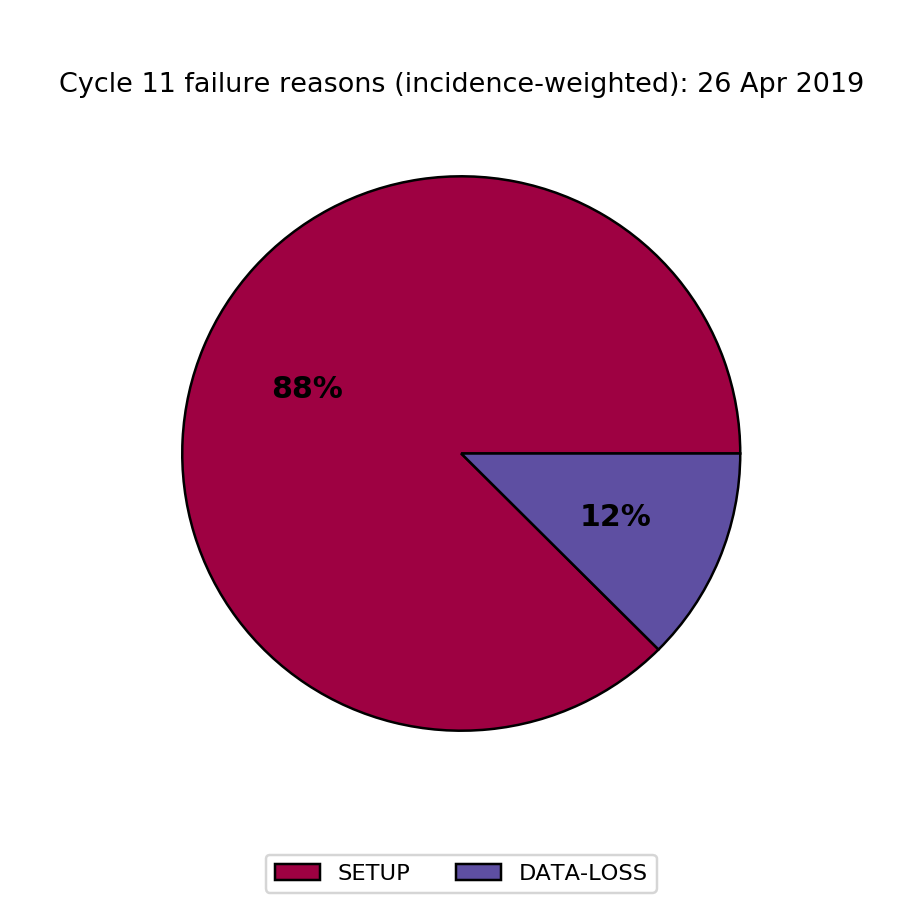

In [8]:
# Make the pie chart - subcategories
subcats = {}
cattime = {}
allcodes = []
catcodes = {}
for i in range(0,len(d)):
    cat = [x.strip() for x in d['Main failure category:'][i].split(',')]
    print(d['Sub-category:'][i])
    subcat = [x.strip() for x in d['Sub-category:'][i].split(',')]
    timelost = d['Number of hours lost:'][i]
    divtime = timelost/float(len(subcat))
    for jj in range(0,len(subcat)):
        ocat = cat[jj]
        j = subcat[jj]
        allcodes.append(j)
        
        # Append to time
        if j in cattime.keys():
            cattime[j]+=divtime
        else:
            cattime[j] = divtime
        
unique = list(set(allcodes))
for x in unique:
    tottime = sum(cattime[x])
    catcodes[x] = allcodes.count(x)#*tottime

sorted_cat = sorted(catcodes.items(), key=operator.itemgetter(1))
values,keys = [],[]
for x in sorted_cat:
    values.append(x[1])
    keys.append(x[0])    
 
print (sorted_cat)

coldict = {}
clist = [cm.Spectral(x) for x in linspace(0,1,len(cattime.keys()))]
clist2 = clist[::-1]
for i in range(0,len(keys)):
    coldict[keys[i]] = clist2[i]
    
print( coldict,clist)
    
figure(figsize=(5,5))
title('%s failure reasons (incidence-weighted): %s' % (cyc,today))
patches,texts,autotexts = pie(values[::-1],labeldistance=1.2,colors=clist,wedgeprops = {'linewidth': 1,'edgecolor':'k'},autopct='%1.0f%%')
legend(tuple(patches), tuple(keys[::-1]), loc=8,ncol=3,bbox_to_anchor=(0.5,-0.15))
masterpatches,masterkeys = patches,keys
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')
    autotext.set_size(12)
savefig('%s/%s_failurereasons_subcategories_%s.png' % (save_loc,''.join(cyc.split()),today_save),bbox_inches='tight',dpi=200)

['HUMAN'] 4.0 ['SETUP']
HUMAN
['HUMAN'] 8.33 ['SETUP']
HUMAN
['NETWORK'] 4.33 ['DATA-LOSS']
NETWORK
['HUMAN'] 4.0 ['SETUP']
HUMAN
['STATION'] 5.0 ['SETUP']
STATION
['STATION'] 1.0 ['SETUP']
STATION
['HUMAN'] 8.0 ['SETUP']
HUMAN
['HUMAN'] 7.0 ['SETUP']
HUMAN
{'DATA-LOSS': (0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0), 'SETUP': (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)}
41.66 [4.33, 37.33]


<IPython.core.display.Javascript object>


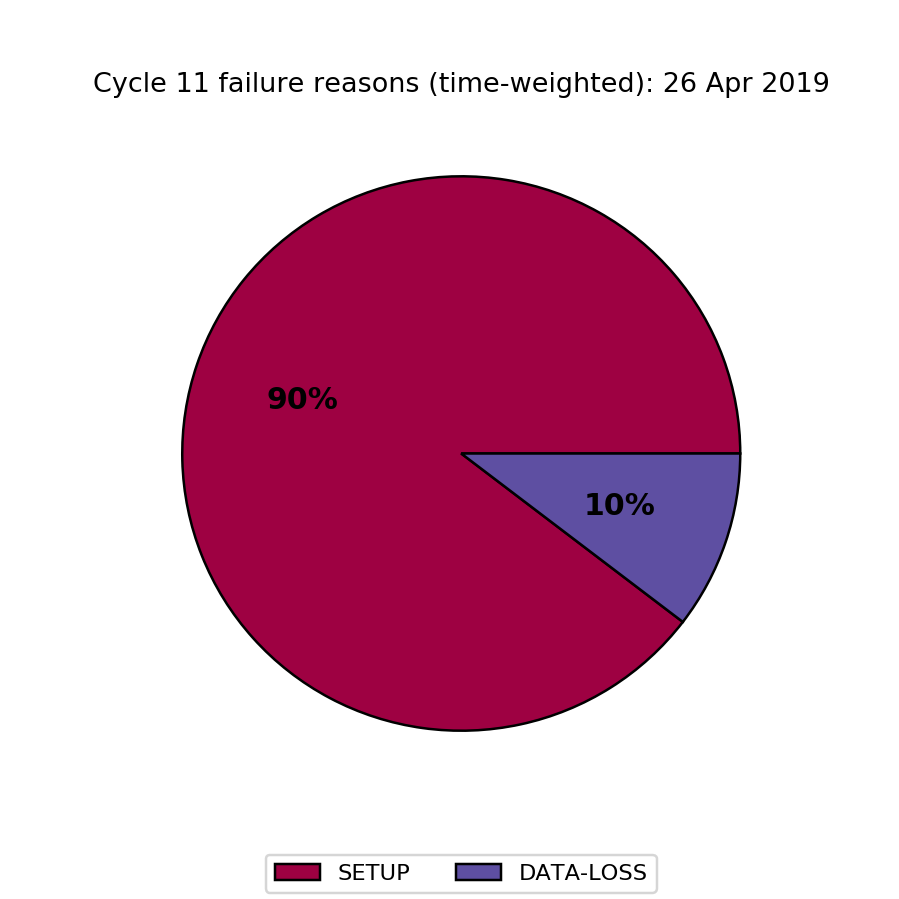

In [9]:
# Make the pie chart - subcategories
subcats = {}
cattime = {}
allcodes = []
catcodes = {}
for i in range(0,len(d)):
    cat = [x.strip() for x in d['Main failure category:'][i].split(',')]
    subcat = [x.strip() for x in d['Sub-category:'][i].split(',')]
    timelost = d['Number of hours lost:'][i]
    divtime = timelost/float(len(subcat))
    
    print (cat,divtime,subcat)
    for jj in range(0,len(subcat)):
        ocat = cat[jj]
        print (ocat)
        j = subcat[jj]
        allcodes.append(j)
        
        # Append to time
        if j in cattime.keys():
            cattime[j]+=divtime
        else:
            cattime[j] = divtime
        
unique = list(set(allcodes))
for x in unique:
    tottime = sum(cattime[x])
    catcodes[x] = allcodes.count(x)#*tottime

sorted_cat = sorted(cattime.items(), key=operator.itemgetter(1))
values,keys = [],[]
for x in sorted_cat:
    values.append(x[1])
    keys.append(x[0]) 

# Keep the same colours
clist = []
print (coldict)
for x in keys:
    clist.append(coldict[x])
    
print( sum(values),values)
    
figure(figsize=(5,5))
title('%s failure reasons (time-weighted): %s' % (cyc,today))
patches,texts,autotexts = pie(values[::-1],labeldistance=1.2,colors=clist[::-1],wedgeprops = {'linewidth': 1,'edgecolor':'k'},autopct='%1.0f%%')
legend(tuple(masterpatches), tuple(masterkeys[::-1]), loc=8,ncol=3,bbox_to_anchor=(0.5,-0.15))
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')
    autotext.set_size(12)
savefig('%s/%s_failurereasons_subcatergories_time_%s.png' % (save_loc,''.join(cyc.split()),today_save),bbox_inches='tight',dpi=200)


<IPython.core.display.Javascript object>


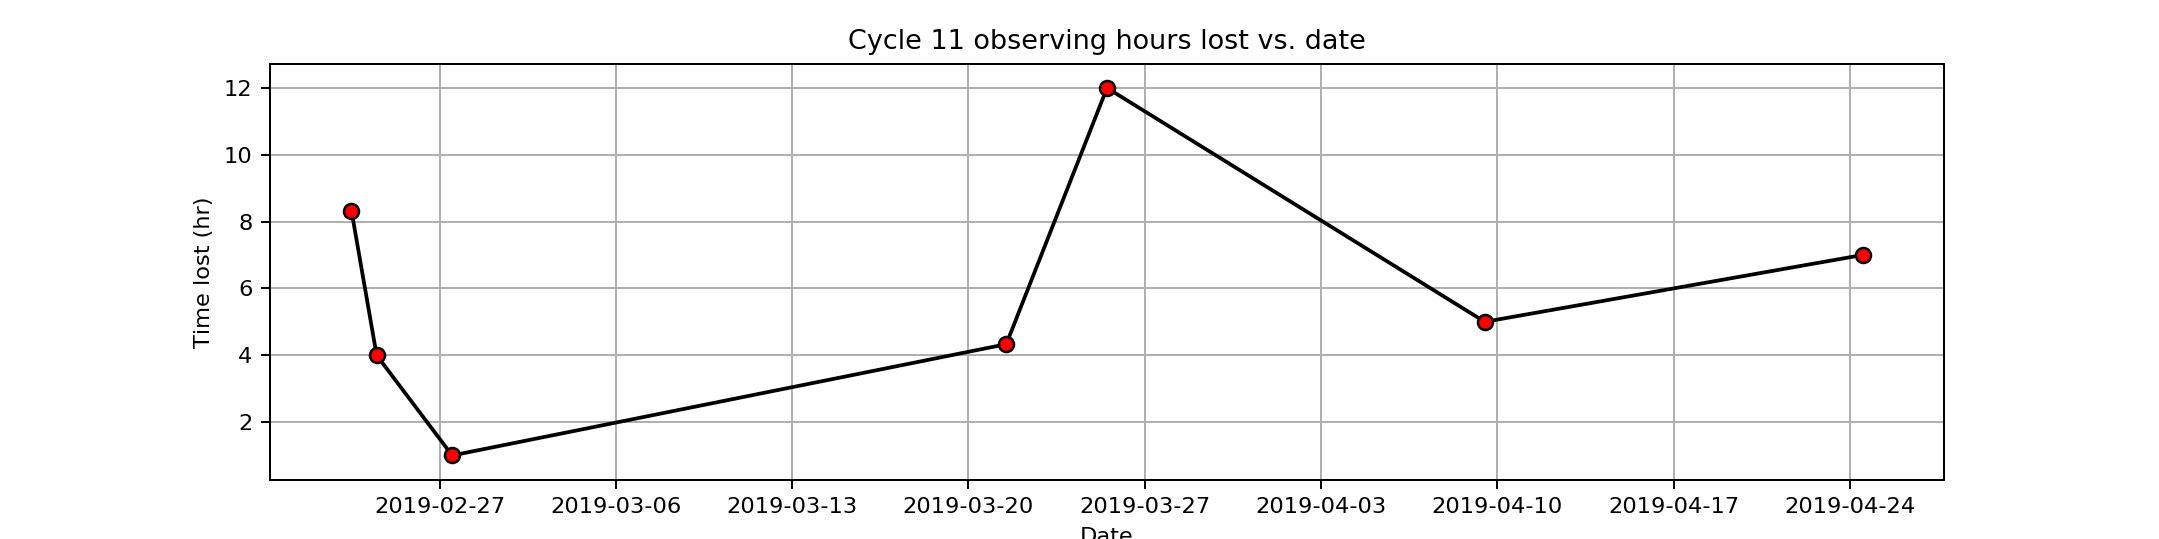

In [10]:
# Plot data loss over time
timelostdate = {}

for i in range(0,len(d)):
    dates = d['Date of observation:'][i].split(',')
    timelost = d['Number of hours lost:'][i]
    divtime = timelost/float(len(dates))
    for j in dates:
        date = datetime.datetime.strptime(j.strip()+' 12:00','%m/%d/%Y %H:%M')
        if date in timelostdate:
            timelostdate[date]+=divtime
        else:
            timelostdate[date]=divtime

figure(figsize=(12,3))
x,y = [],[]
for i in sorted(timelostdate):
    x.append(i)
    y.append(timelostdate[i])
plot(x,y,'k-')    
scatter(x,y,marker='o',facecolor='r',edgecolor='k',zorder=100)    
xlabel('Date')
ylabel('Time lost (hr)')
grid(True)
title('%s observing hours lost vs. date' % (cyc))
savefig('%s/%s_timelostvsdate_%s.png' % (save_loc,''.join(cyc.split()),today_save),bbox_inches='tight',dpi=200)

<IPython.core.display.Javascript object>


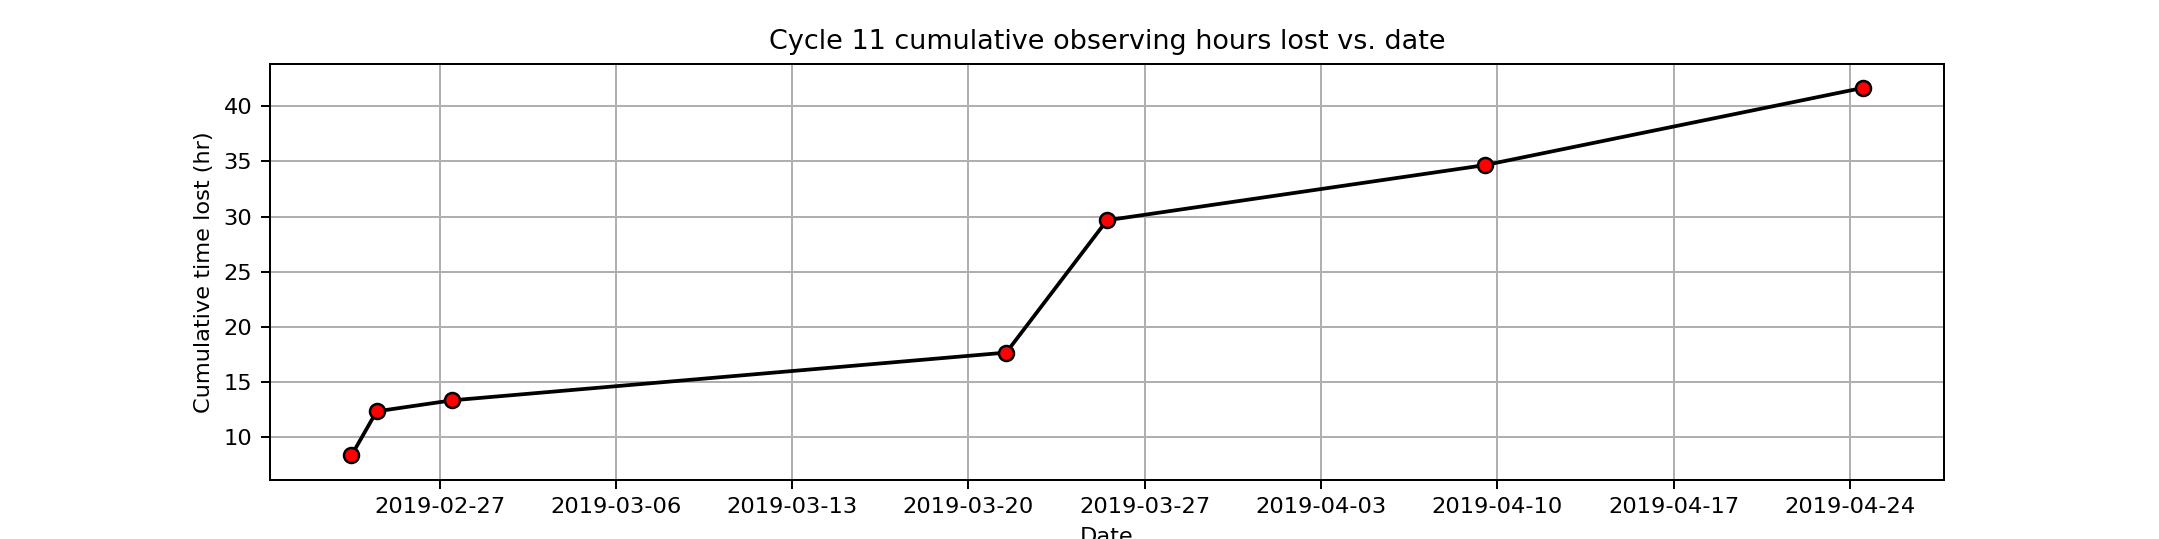

In [11]:
# Cumulative time lost
x = np.array(x)
ycumu = []
for i in range(0,len(x)):
    j = sum(y[0:i+1])
    ycumu.append(j)

allx = x
ally = ycumu    
    
figure(figsize=(12,3))
plot(x,ycumu,'k-')    
scatter(x,ycumu,marker='o',facecolor='r',edgecolor='k',zorder=100)    
xlabel('Date')
ylabel('Cumulative time lost (hr)')
grid(True)
title('%s cumulative observing hours lost vs. date' % (cyc))
savefig('%s/%s_timelostvsdate_cumulative_%s.png' % (save_loc,''.join(cyc.split()),today_save),bbox_inches='tight',dpi=200)

In [12]:
print (sum(d['Number of hours lost:']))

41.66


<IPython.core.display.Javascript object>


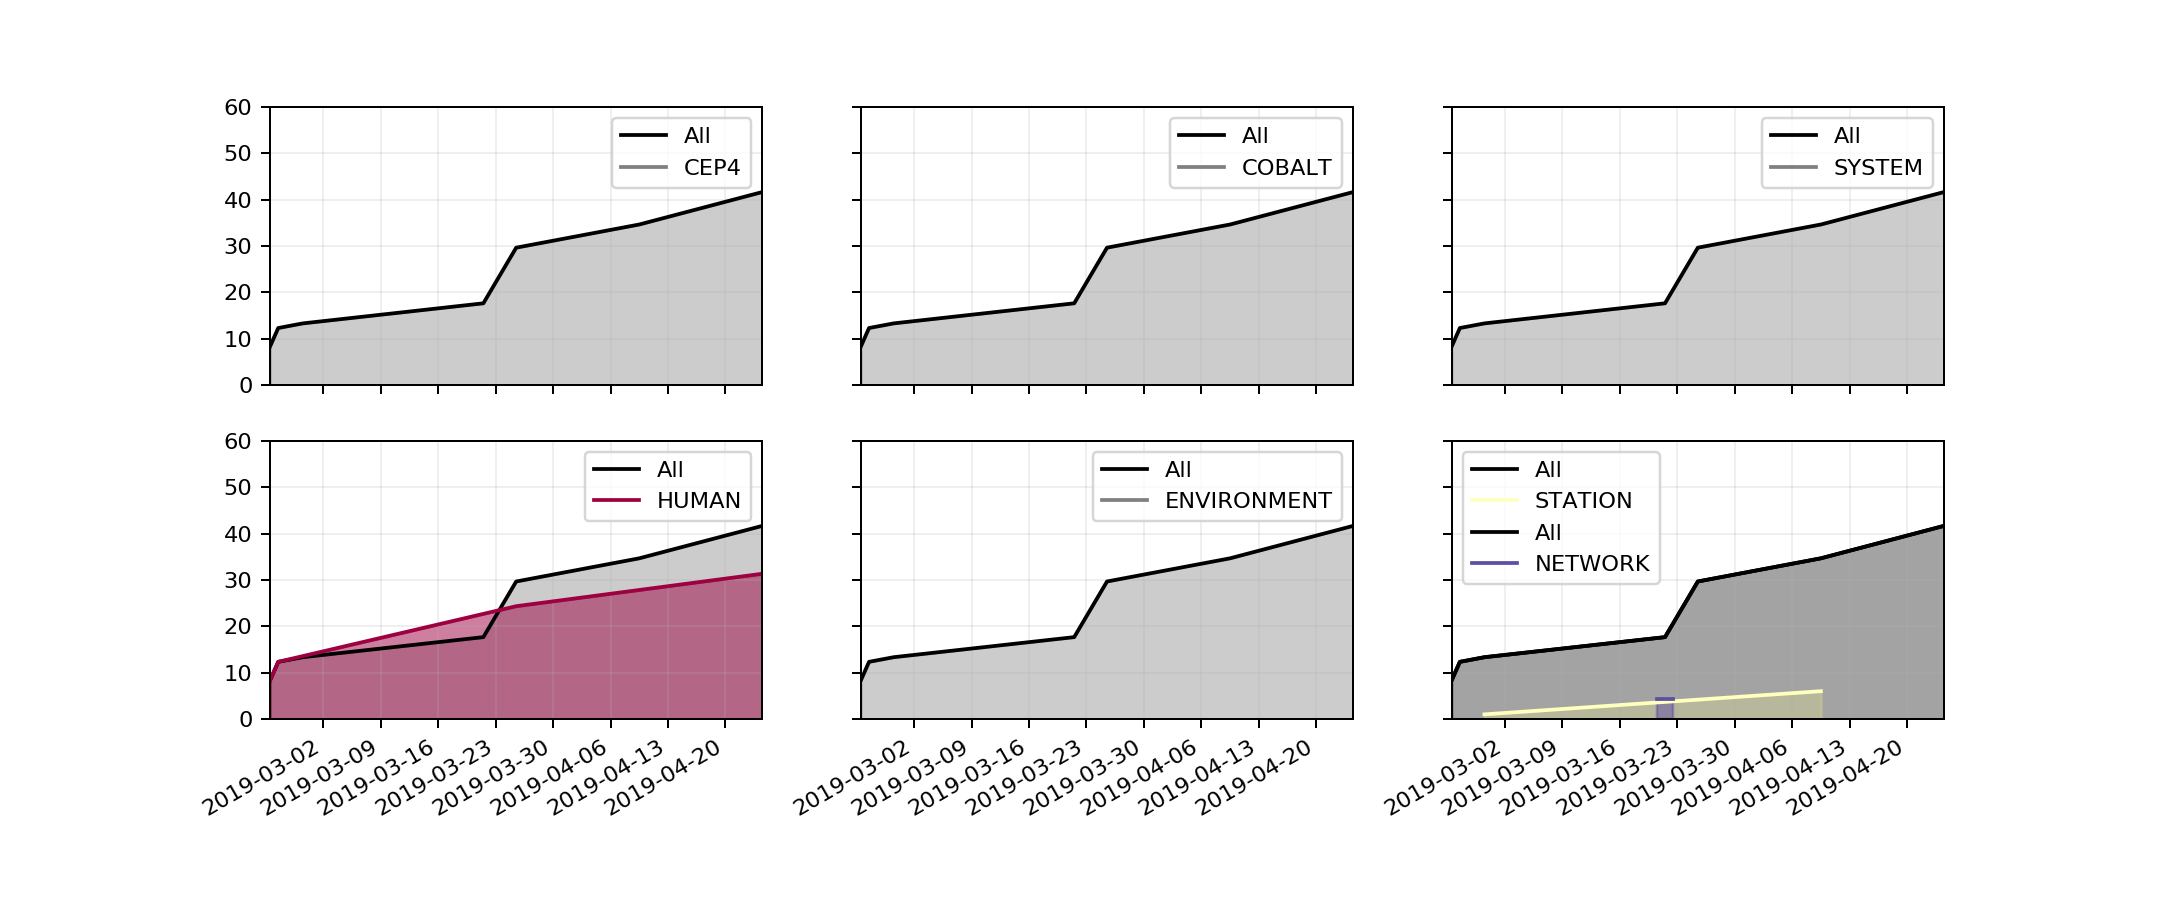

dict_keys(['STATION', 'CEP4', 'COBALT', 'SYSTEM', 'HUMAN', 'ENVIRONMENT', 'NETWORK'])


In [13]:
# Plot data loss in particular categories over time
catloss = {'STATION':[],'CEP4':[],'COBALT':[],'SYSTEM':[],'HUMAN':[],'ENVIRONMENT':[]}
alldates = []

for i in range(0,len(d)):
    dates = d['Date of observation:'][i].split(',')
    timelost = d['Number of hours lost:'][i]
    category = d['Main failure category:'][i].split(',')
    divtime = timelost/float(len(dates))
    for k in category:
        k = k.strip()
        for j in dates:
            date = datetime.datetime.strptime(j.strip()+' 12:00','%m/%d/%Y %H:%M')
            alldates.append(date)
            if k in catloss:
                catloss[k].append([date,divtime])
            else:
                catloss[k] = [[date,divtime]]
            
fig1, axes1 = subplots(nrows=2, ncols=3,sharex=True, sharey=True,figsize=(12,5))
print (catloss.keys())

for i in range(0,len(catloss)):
    key = list(catloss.keys())[i]
    subloss = {}
    subset = catloss[key]
    label = key
    for j in subset:
        if j[0] in subloss:
            subloss[j[0]]+=j[1]
        else:
            subloss[j[0]]=j[1]
    x,y = [],[]
    for k in sorted(subloss):
        x.append(k)
        y.append(subloss[k])
        
    # Cumulative time lost
    xx,yy = int(ceil(i/3.)), i % 3
    if yy == 0:
        yy = 3
    ax = axes1[xx-1,yy-1]  
    x = np.array(x)
    ycumu = []
    for l in range(0,len(x)):
        j = sum(y[0:l+1])
        ycumu.append(j)
    #colr = cm.Spectral(float(i)/(len(catloss)-1))
    ax.grid(True,alpha=0.2)
    ax.plot(allx,ally,'-',color='k',label='All')
    ax.fill_between(allx,y1=0,y2=ally,color='k',alpha=0.2)
    
    # Get colour
    if key in coldictcat.keys():
        colr = coldictcat[key]
    else:
        colr = 'gray'
    
    # Deal with single point failures
    x = list(x)
    if len(x) == 1:
        xnew = []
        ynew = []
        xnew.append(x[0] - datetime.timedelta(days=1))
        xnew.append(x[0])
        xnew.append(x[0] + datetime.timedelta(days=1))
        ynew.append(y[0])
        ynew.append(y[0])
        ynew.append(y[0])
        x = xnew
        ycumu = ynew
        
    ax.plot(x,ycumu,'-',color=colr,label=key)    
    ax.fill_between(x,y1=0,y2=ycumu,color=colr,alpha=0.5)
    ax.set_xlim(min(alldates),max(alldates))
    ax.set_ylim(0,60)
    ax.legend(loc=0)
    fig1.autofmt_xdate()
    
    
#xlabel('Date')
#ylabel('Time lost (hr)')
#title('Cycle 8 observing hours lost vs. date')
savefig('%s/%s_timelostvsdate_categories_%s.png' % (save_loc,''.join(cyc.split()),today_save),bbox_inches='tight',dpi=200)

input/Cycle8-Part1.csv
['DATE', 'OBSERVING HOURS LOST']
input/Cycle8-Part2.csv
['PROJECT CODE', 'SASid', 'FAILURE TYPE', 'col3', 'FAILURE CATEGORY', 'SUBCATEGORY', 'DATE', 'OBSERVING HOURS LOST', 'LST RANGE', 'IS THIS A REPEAT?  (Y/N)', 'IS THIS AN RO FAILURE ONLY (Y/N)', 'NOTES']
input/Cycle9-Part1.csv
['PROJECT CODE', 'SASid', 'FAILURE TYPE', 'col3', 'FAILURE CATEGORY', 'SUBCATEGORY', 'DATE', 'OBSERVING HOURS LOST', 'LST RANGE', 'IS THIS A REPEAT?  (Y/N)', 'IS THIS AN RO FAILURE ONLY (Y/N)', 'NOTES']
input/Cycle9-Part2.csv
['PROJECT CODE', 'SASid', 'FAILURE TYPE', 'col3', 'FAILURE CATEGORY', 'SUBCATEGORY', 'DATE', 'OBSERVING HOURS LOST', 'LST RANGE', 'IS THIS A REPEAT?  (Y/N)', 'PI ACCEPTED DATA ANYWAY (Y/N)', 'NOTES']
input/Cycle10-Part1.csv
['PROJECT CODE', 'SASid', 'FAILURE TYPE', 'FAILURE CATEGORY', 'SUBCATEGORY', 'DATE', 'OBSERVING HOURS LOST', 'LST RANGE', 'IS THIS A REPEAT?  (Y/N)', 'PI ACCEPTED DATA ANYWAY (Y/N)', 'NOTES', 'THIS', 'COLUMN', 'IS', 'ANNOYING']
input/Cycle10-Par

<IPython.core.display.Javascript object>


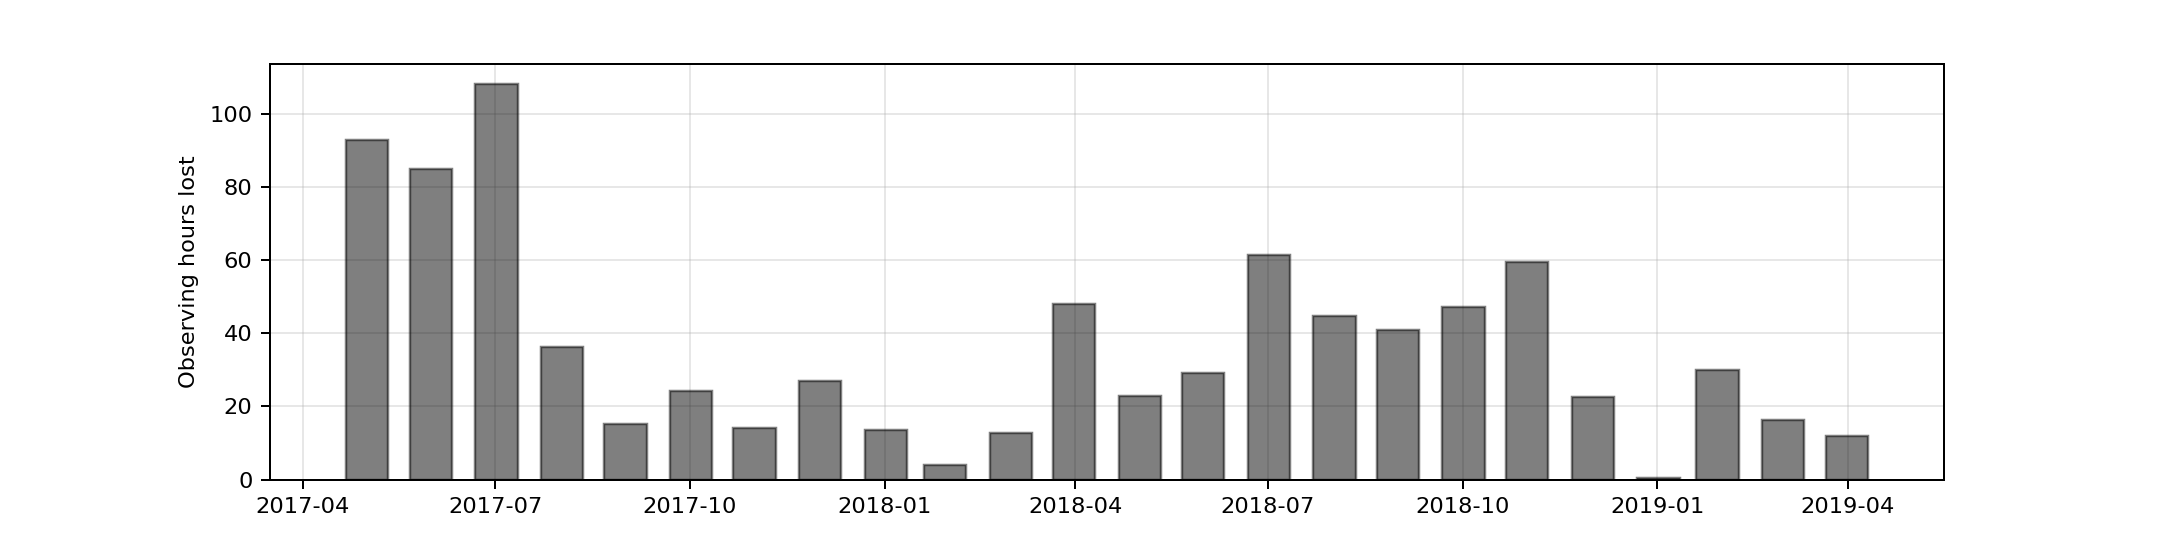

In [14]:
# Historical plot
from historical_failures import *
plot_historical_failures(files,save_loc,cyc)